# Processor for Fiducial Detection

This Notebook is testing the fiducial detection processor in DataSTORM.

In [1]:
# Standard initialization
%pylab
%matplotlib inline
import pandas as pd
from pathlib import Path
import trackpy as tp

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import test dataset
fileName = Path('../test-data/acTub_COT_gain100_30ms/acTub_COT_gain100_30ms.csv')
with open(str(fileName), 'r') as file:
    testData = pd.read_csv(file)

In [3]:
testData.describe()

,x,x-uncertainty,y,y-uncertainty,frame,ad-count,chi-square,background
count,214717.000000,214717.000000,214717.000000,214717.000000,214717.000000,214717.000000,214717.000000,214717.000000
mean,2425.196663,35.420145,2182.946881,35.420145,5172.075346,6288.638717,1029.127987,744.422318
std,1595.345619,20.475942,1322.208205,20.475942,2777.221724,15586.487514,2896.254531,312.086668
min,0.000001,0.847267,0.000002,0.847267,0.000000,338.324000,50.035500,523.371000
25%,965.218000,20.430100,982.750000,20.430100,2904.000000,577.636000,222.657000,613.929000
50%,2403.570000,38.192700,2206.350000,38.192700,5165.000000,772.204000,304.708000,656.426000
75%,3892.590000,50.197000,3461.780000,50.197000,7563.000000,1596.560000,433.924000,730.572000
max,4900.000000,80.431400,4200.000000,80.431400,9999.000000,177421.000000,58298.300000,7147.530000


## Group localizations in time

Now that we have the data, let's merge the localizations together by those that fall within a certain distance and a given time. We'll use TrackPy for this because DataSTORM's Merger does some unnecessary stuff. Merger is designed to specifically merge localization data, which includes some additional steps like adding photons and uncertainty handling which complicate matters. For now, we'll stick with what is most simple.

In [4]:
# Merge localizations
mergeRadius = 90
offTime     = 3
mergedLocs  = tp.link_df(testData, mergeRadius, memory = offTime)

Frame 9999: 18 trajectories present


Now we can assume that fiducial tracks are relatively long-lived, so let's remove short trajectories from the DataFrame using TrackPy's *filter_stubs()* function. First we'll look at the histogram of track lengths.

In [5]:
trackLengths = mergedLocs.groupby('particle').size()

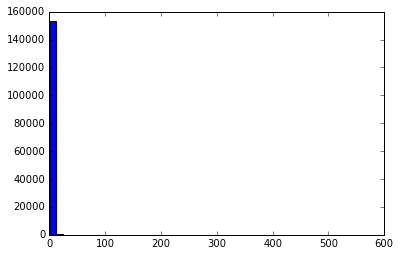

In [6]:
plt.hist(trackLengths, bins= 50)
plt.show()

OK, so most tracks are probably single molecules. What happens when we filter out the tracks with less than, say, twenty localizations?

In [7]:
minimumTrackLength = 20

# Note that TrackPy's *filter_stubs()* function seems a bit slow.
# Perhaps pure Pandas with groupby filering would work better?
mergedFilteredLocs = tp.filter_stubs(mergedLocs, minimumTrackLength)

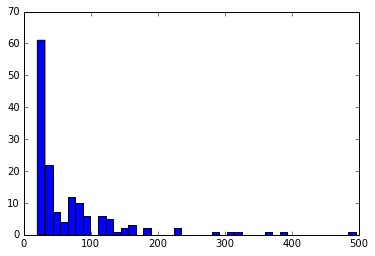

In [8]:
# Plot the histogram of track lengths after filtering by a minimum number
newTrackLengths = mergedFilteredLocs.groupby('particle').size()
plt.hist(newTrackLengths.as_matrix(), bins = 50)
plt.xlim((0,500))
plt.show()

There are a few long-lived tracks which may well belong to the fiducial(s). Let's set the minimum track length to 30 localizations to see what changes.

In [9]:
minimumTrackLength = 30

# Note that TrackPy's *filter_stubs()* function seems a bit slow.
# Perhaps pure Pandas with groupby filering would work better?
mergedFilteredLocs = tp.filter_stubs(mergedLocs, minimumTrackLength)

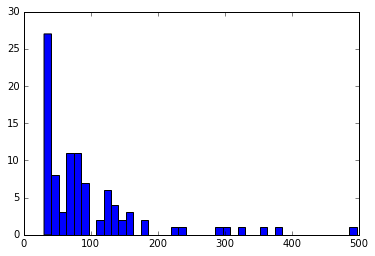

In [10]:
# Plot the histogram of track lengths after filtering by a minimum number
newTrackLengths = mergedFilteredLocs.groupby('particle').size()
plt.hist(newTrackLengths.as_matrix(), bins = 50)
plt.xlim((0,500))
plt.show()

In [11]:
mergedFilteredLocs.describe()

,x,x-uncertainty,y,y-uncertainty,frame,ad-count,chi-square,background,particle
count,10078.000000,10078.000000,10078.000000,10078.000000,10078.000000,10078.000000,10078.000000,10078.000000,10078.000000
mean,1718.056725,5.092660,2633.926495,5.092660,5007.619667,12951.721164,1519.392988,786.478364,70764.433022
std,647.911331,3.739202,463.492007,3.739202,2819.546608,9965.749905,2510.969923,154.391682,45628.252289
min,23.392400,0.977764,0.006614,0.977764,301.000000,438.225000,87.973200,564.622000,2379.000000
25%,1569.440000,3.629900,2529.760000,3.629900,2511.250000,9442.132500,625.897250,694.107250,25925.000000
50%,1579.195000,4.144295,2556.655000,4.144295,4850.500000,11393.750000,764.609000,734.202500,69142.000000
75%,1590.257500,4.749500,2577.707500,4.749500,7559.750000,13934.425000,1138.075000,821.576250,113955.000000
max,4684.590000,75.082800,4190.090000,75.082800,9999.000000,140588.000000,34351.100000,2251.400000,152016.000000


## Spatial clustering of tracks

Now let's see whether the centers of mass of these tracks correspond to the actual fiducial location.

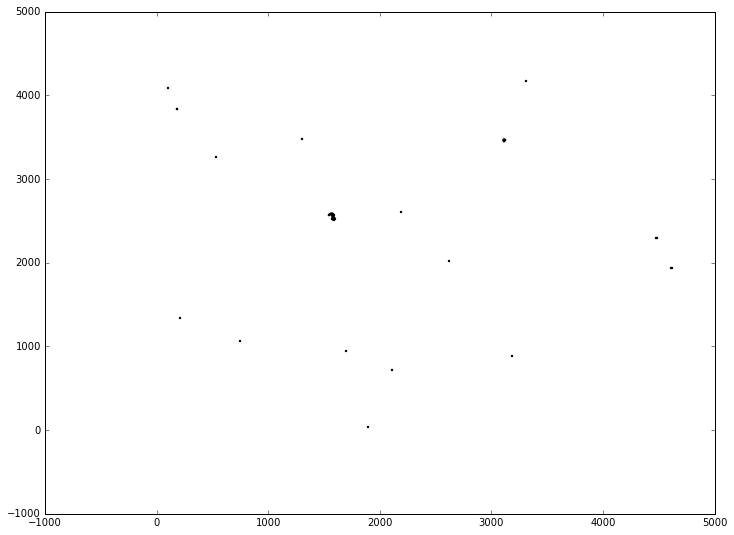

In [12]:
# Plot the centers of mass of the tracks
candidates   = mergedFilteredLocs.groupby('particle')
clusterStats = candidates.aggregate(np.mean)

fig = plt.figure(figsize = (12,9))
plt.scatter(clusterStats['x'], clusterStats['y'], s=2)
plt.show()

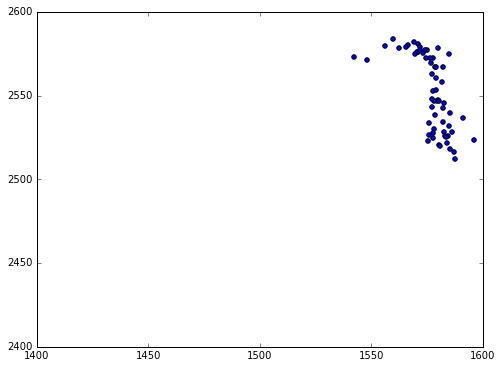

In [13]:
fig = plt.figure(figsize = (8,6))
plt.scatter(clusterStats['x'], clusterStats['y'])
plt.xlim((1400, 1600))
plt.ylim((2400, 2600))
plt.show()

The cluster around (1500, 2500) corresponds to the real fiducial, but I only know this because I have seen the raw tiff stack.

Before seeing if we can isolate this set of points automatically, let's see what the combined fiducial tracks look like...

In [14]:
temp = mergedFilteredLocs[np.logical_and(mergedFilteredLocs['x'] > 1500, mergedFilteredLocs['x'] < 1700)]
temp = temp[np.logical_and(temp['y'] > 2500, temp['y'] < 2600)]

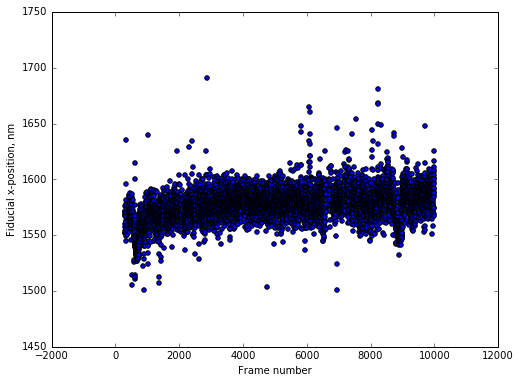

In [15]:
plt.figure(figsize = (8,6))
plt.scatter(temp['frame'], temp['x'])
plt.xlabel('Frame number')
plt.ylabel('Fiducial x-position, nm')
plt.show()

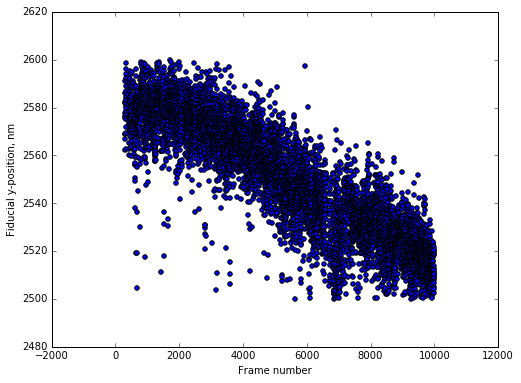

In [16]:
plt.figure(figsize = (8,6))
plt.scatter(temp['frame'], temp['y'])
plt.xlabel('Frame number')
plt.ylabel('Fiducial y-position, nm')
plt.show()

These results match qualitatively with Niklas's fiducial detection on this dataset, though I would say that what is in this notebook is currently a bit more noisy than Niklas's results.

Let's now try automatic detection of the fiducials. We can apply two pieces of knowledge here to identify the fiducials:

1. The final fiducial track should span most of the full image stack
2. The fiducial track cannot contain localizations with the same frame numbers

A problem might arise if two tracks are clustered together but contain the same frame numbers. One way to circumvent this problem is to remove both tracks. Another is to keep the longer track, though this does not guarantee we chose the correct one. Yet another option is to reject both tracks unless one is especially long-lived, such as one track of length 20 vs. one track of length 100. This would require another free parameter, but would likely guarantee that the longer track was the correct one.

After clustering, we can check that the final track spans the full stack by saying that it must be at least half as long as the full stack length. I do not suspect that false positive rates will not be very high at the end of this routine.


One other quick note is that we can cluster by the tracks' centers of mass or by the all the localizations together. It may be better to cluster by all the localizations instead of their centers of mass since a very good fiducial may consist of only one track and would not therefore appear as a spatial cluster of tracks.

In [17]:
from sklearn.cluster import DBSCAN

# Perform spatial clustering with min_pts = 3/4 the stack length
maxFrame           = mergedFilteredLocs['frame'].max() - mergedFilteredLocs['frame'].min()
neighborhoodRadius = 100 # same units as x and y

db = DBSCAN(eps = neighborhoodRadius, min_samples = maxFrame * 0.75)
db.fit(mergedFilteredLocs[['x', 'y']])

DBSCAN(algorithm='auto', eps=100, leaf_size=30, metric='euclidean',
    min_samples=7273.5, p=None, random_state=None)

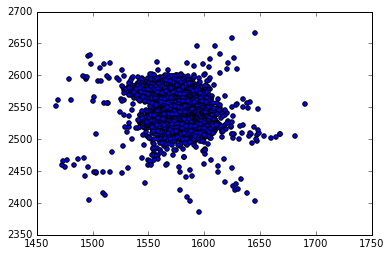

In [18]:
plt.scatter(mergedFilteredLocs['x'][db.labels_ == 0], mergedFilteredLocs['y'][db.labels_ == 0])
plt.show()

In [19]:
# If more than one candidate was found, I will have to find another way to use labels below.
# Possibly, I could create multiple frames for each candidate.
fiducialCandidate = mergedFilteredLocs[db.labels_ == 0]
uniqueTracks      = np.unique(fiducialCandidate['particle']).size

print('There are {0} unique tracks in this fiducial candidate.'.format(uniqueTracks))
fiducialCandidate.head()

There are 62 unique tracks in this fiducial candidate.


,x,x-uncertainty,y,y-uncertainty,frame,ad-count,chi-square,background,particle
frame,,,,,,,,,
301,1569.75,3.66970,2577.83,3.66970,301,14394.60,753.021,915.002,2379
302,1552.08,3.96149,2591.07,3.96149,302,13452.20,783.827,1046.220,2379
303,1571.33,4.50682,2586.21,4.50682,303,11565.60,968.928,1126.060,2379
304,1576.39,4.47053,2566.97,4.47053,304,11447.30,1099.850,1056.770,2379
305,1567.48,5.78385,2582.08,5.78385,305,8967.98,6012.320,1353.580,2379


In [20]:
fiducialCandidate.describe()

,x,x-uncertainty,y,y-uncertainty,frame,ad-count,chi-square,background,particle
count,8323.000000,8323.000000,8323.000000,8323.000000,8323.000000,8323.000000,8323.000000,8323.000000,8323.000000
mean,1577.050991,3.973366,2549.760389,3.973366,5277.963955,14032.229009,1620.819658,787.858318,75011.551964
std,15.162252,0.887281,25.924167,0.887281,2777.495950,8304.553684,2580.014062,149.541369,44855.230340
min,1467.090000,1.066110,2385.920000,1.066110,301.000000,2973.250000,448.732000,641.000000,2379.000000
25%,1569.555000,3.554605,2529.665000,3.554605,2937.500000,10359.300000,671.858500,697.014500,35909.000000
50%,1577.710000,4.017480,2551.460000,4.017480,5223.000000,11926.900000,802.191000,735.051000,71897.000000
75%,1585.795000,4.429720,2571.100000,4.429720,7776.500000,14375.700000,1205.115000,820.584000,116235.000000
max,1690.800000,17.099700,2667.190000,17.099700,9996.000000,115735.000000,34351.100000,2251.400000,151081.000000


This operation seemed to capture most of the localizations that belonged to the fiducial. (Note that the x- and y-axes are similar to the one identified by the track centers of mass above.) Now that we have a cluster of localizations, let's ensure that there are no "extra" localizations that were erroneously mixed into this cluster. Because the time-scale of lateral drift is rather small and we will be smoothing the fiducial trajectory anyway, we can probably just remove rows that have duplicate frame counts without bad effects.

In [21]:
# Create a boolean array where True elements correspond to duplicated frames
# NOTE: CAN BE DONE WITH DROP DUPLICATES
#duplicates        = fiducialCandidate.duplicated('frame')

# Use the duplicate mask to filter out repeated localizations
fiducialCandidate.drop_duplicates(subset = 'frame', keep = False, inplace = True)
fiducialCandidate.head()

/home/douglass/anaconda3/envs/DataSTORM/lib/python3.5/site-packages/pandas/util/decorators.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


,x,x-uncertainty,y,y-uncertainty,frame,ad-count,chi-square,background,particle
frame,,,,,,,,,
301,1569.75,3.66970,2577.83,3.66970,301,14394.60,753.021,915.002,2379
302,1552.08,3.96149,2591.07,3.96149,302,13452.20,783.827,1046.220,2379
303,1571.33,4.50682,2586.21,4.50682,303,11565.60,968.928,1126.060,2379
304,1576.39,4.47053,2566.97,4.47053,304,11447.30,1099.850,1056.770,2379
305,1567.48,5.78385,2582.08,5.78385,305,8967.98,6012.320,1353.580,2379


In [23]:
locCounts  = fiducialCandidate['frame'].count()
uniqueLocs = np.unique(fiducialCandidate['frame']).size

print('The number of localizations in this fiducial candidate is {0} and the number of unique frames is {1}'.format(locCounts, uniqueLocs))
print('Number of localizations equal to number of unique frames?')
print(locCounts == uniqueLocs)

The number of localizations in this fiducial candidate is 8321 and the number of unique frames is 8321
Number of localizations equal to number of unique frames?
True


Now that I have a number of localizations all corresponding to a fiducial, let's plot its x- and y- localizations as a function of time.

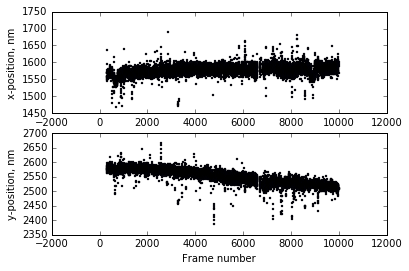

In [24]:
fig, axarr = plt.subplots(2, 1)
axarr[0].scatter(fiducialCandidate['frame'], fiducialCandidate['x'], s = 2)
axarr[1].scatter(fiducialCandidate['frame'], fiducialCandidate['y'], s = 2)

axarr[0].set_ylabel('x-position, nm')
axarr[1].set_ylabel('y-position, nm')
axarr[1].set_xlabel('Frame number')
plt.show()

## Creating drift correction curves from the data
Now that we have samples from the fiducial track over time, we need to smooth the curves and create trajectories to correct the original localization data with. For this, I'll use Niklas's smoothing spline approach.

In [25]:
# Import functions for using the smoothing splines
from scipy.signal      import gaussian
from scipy.ndimage     import filters
from scipy.interpolate import UnivariateSpline

In [26]:
# Define a function for estimating the correct smoothing factor
def movingAverage(series, windowSize=100, sigma=3):
    # From: http://www.nehalemlabs.net/prototype/blog/2014/04/12/how-to-fix-scipys-interpolating-spline-default-behavior/
    b       = gaussian(windowSize, sigma)
    average = filters.convolve1d(series, b/b.sum())
    var     = filters.convolve1d(np.power(series-average,2), b/b.sum())
    return average, var

In [57]:
# Estimate the smoothing factor for the spline fit
# The magic numbers 10.0 and 25.0 come from Niklas; they prevent severe fluctuations in the spline from occurring
approxNumFrames = fiducialCandidate['frame'].max() - fiducialCandidate['frame'].min()
windowSize      = approxNumFrames / 30.0
sigma           = approxNumFrames / 50.0

_, varx = movingAverage(fiducialCandidate['x'], windowSize = windowSize, sigma = sigma)
_, vary = movingAverage(fiducialCandidate['y'], windowSize = windowSize, sigma = sigma)

# Fit an interpolative smoothing spline to the data
xSpline = UnivariateSpline(fiducialCandidate['frame'].as_matrix(), fiducialCandidate['x'].as_matrix(), w = 1/np.sqrt(varx), ext=3)
ySpline = UnivariateSpline(fiducialCandidate['frame'].as_matrix(), fiducialCandidate['y'].as_matrix(), w = 1/np.sqrt(vary), ext=3)

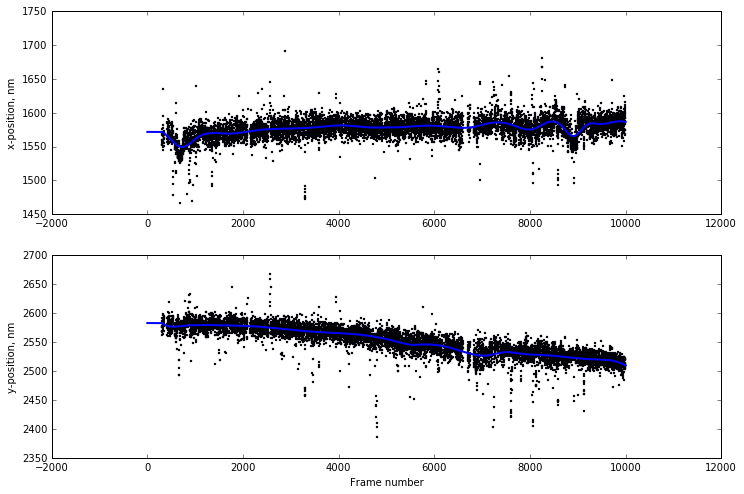

In [58]:
frames = np.arange(0, 10000)
fig, axarr = plt.subplots(2, 1, figsize = (12,8))
axarr[0].scatter(fiducialCandidate['frame'], fiducialCandidate['x'], s = 2)
axarr[0].plot(frames, xSpline(frames), linewidth = 2)

axarr[1].scatter(fiducialCandidate['frame'], fiducialCandidate['y'], s = 2)
axarr[1].plot(frames,ySpline(frames), linewidth = 2)

axarr[0].set_ylabel('x-position, nm')
axarr[1].set_ylabel('y-position, nm')
axarr[1].set_xlabel('Frame number')
plt.show()

# Comparison to Niklas's algorithm

My algorithm for automatic fiducial detection starts off the same as Niklas's. For example, once the candidate tracks were identified, he then removed tracks with fewer than a relatively large length. This was called his **segmentThreshold** parameter and what I called **minimumTrackLength** above.

From here, Niklas did another, more stringent round of grouping to find the fiducials. In his implementation, the tracks that survived the initial thresholding were linked using **fiducialGap** and **fiducialRadius** parameters. He also set an absolute minimum track length called **fiducialLenThres** for fiducials that was quite large, such as a few thousand.

In my implementation, I performed spatial clustering to group tight clusters of localizations after the initial filtering by track. I set DBSCAN's **min_pts** to a significant fraction (between 1/2 to 3/4) of the total number of frames, which is analogous to Niklas's fiducialLenThres. The **neighbhoorRadius** for DBSCAN is analogous to Niklas's **fiducialLenThres**. Finally, a parameter similar to fiducialGap is not needed because of the pruning of the clusters.